# Metabolic library construction - KEGG
Using an API service KEGG annotations (enzymes, reactions, compounds and pathways) will be collected for all the organisms in our collection.

written by: Shany ofaim @ Cultivarium

In [1]:
# import cell
import pandas as pd 
from bioservices import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
from ete3 import NCBITaxa
import re
from matplotlib_venn import venn3
import math
import sys
import multiprocessing as mp
from time import time, sleep

Step 1 - import organism file.

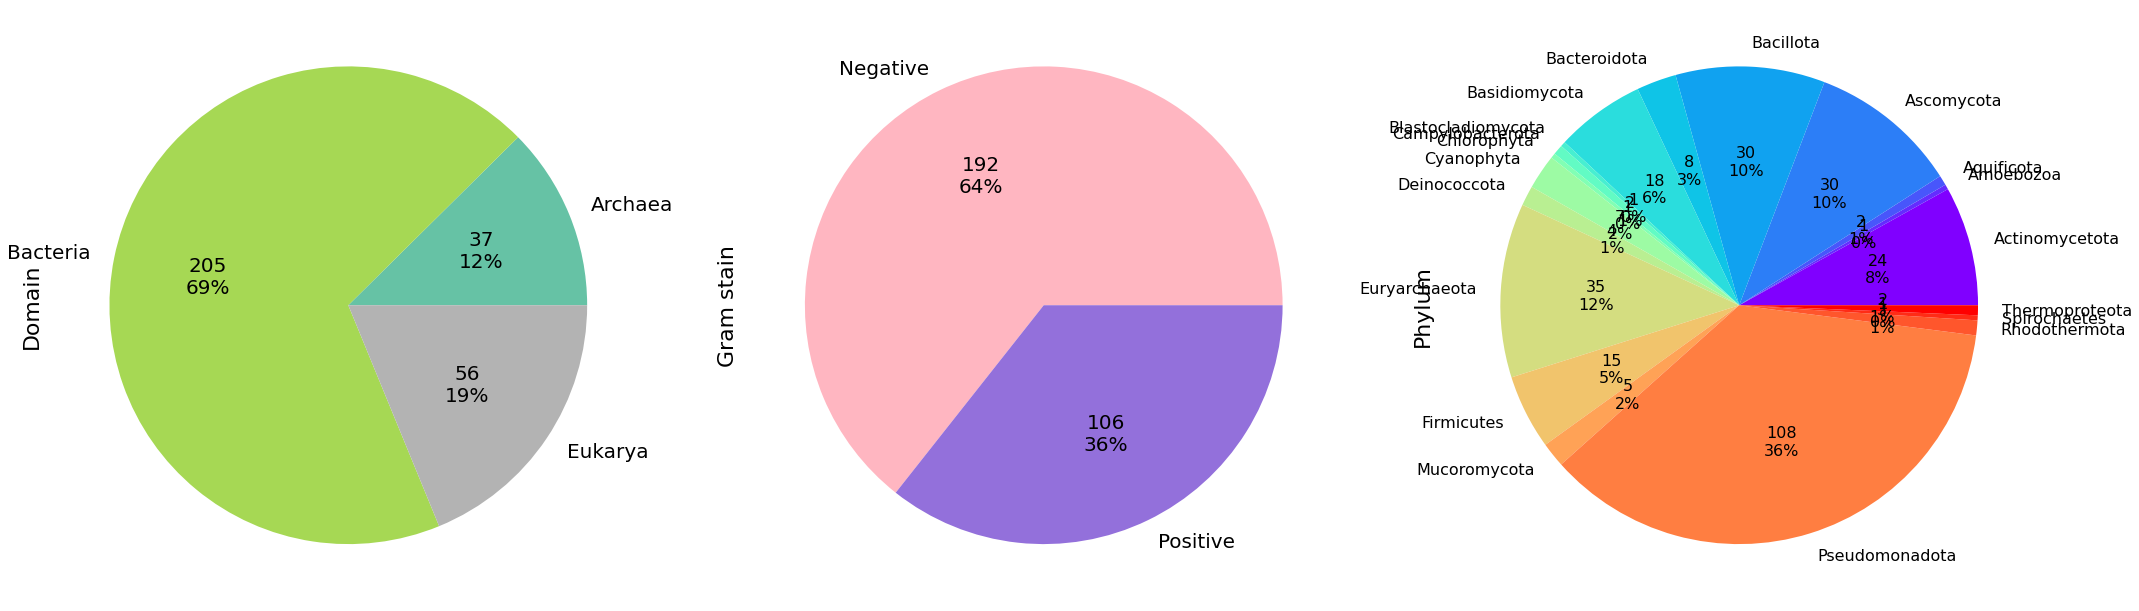

In [2]:
orgsdf=pd.read_csv('org_list.csv')

# try to make pie charts out of columns in the dataframe
def label_function(val):
    return f'{val / 100 * len(orgsdf):.0f}\n{val:.0f}%'
cmap1 = cm.get_cmap('Paired')
cmap2=cm.get_cmap('Set2')
cmap3=cm.get_cmap('rainbow')

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(30, 40))

orgsdf.groupby('Domain').size().plot(kind='pie', autopct=label_function, 
                                    textprops={'fontsize': 20}, cmap=cmap2,
                                    ax=ax1)
orgsdf.groupby('Gram stain (bacteria)').size().plot(kind='pie', autopct=label_function, 
                                                    textprops={'fontsize': 20}, ax=ax2, colors=['lightpink','mediumpurple'])

orgsdf.groupby('Phylum').size().plot(kind='pie', autopct=label_function, 
                                    textprops={'fontsize': 16}, ax=ax3, cmap=cmap3 ) 

ax1.set_ylabel('Domain', size=22)
ax2.set_ylabel('Gram stain', size=22)
ax3.set_ylabel('Phylum', size=22)

plt.tight_layout()
plt.savefig('orgstats-basic.svg')
plt.show()


Get a local copy of NCBI taxonomy to work with organism taxid conversions.

In [3]:
# load the organism list and build primary dataframe for tree construction
ncbi=NCBITaxa()
# update the database only once
#ncbi.update_taxonomy_database()

# Get KEGG organism codes for the organism list. 
Organisms are compared through their NCBI taxids. some organism queries to KEGG retreive multiple results, in this case the taxid will be the deciding factor. Last resort soultion is manual identification of kegg organism id.

In [4]:
kegg=KEGG()
multikorgs=set()
modf=pd.DataFrame()
keggids=[]
keggidset=set()
notinkegg=set()
keggorgs=set()
korgstaxids=set()
keggid2name={}

for org in tqdm(orgsdf['Species']):
    flag=False
    ogorg=org
    if '\n' in org:
        #print(org)
        
        org=org.replace('\n  ',' ')
        #print(org)
    test=kegg.lookfor_organism(org)
    #print(test)
    # what if the organism is not in kegg
    if len(test)==0:
        notinkegg.add(org)
        keggids.append('N/A')
        flag=True
        continue
    stest=test[0].split(' ')
    #print(test)
    if len(test)>1:
        # get the taxid and save the organisms for discussion.
        # look for a taxid match with queried org
        dfl=orgsdf[orgsdf['Species']==ogorg]
        for item in test:
            # split string with regex ^[Tt]\d+ ([a-z][a-z][a-z]) (\w+.*) ([PE]\w+.*)
            restr=re.search(r'^[Tt]\d+ ([a-z]{3,4}) (\w+.*) ([PE]\w+.*)', item)
            '''if not restr:
                break'''
            korg = restr.group(1)
            # add organisms manully curated for kegg orgid
            if any(x in korg for x in ['afe','bth','bcep','cly','cgb','eco','ptl','hanr','ilo','mmad','pfu','sai','syu','syf','syn','ttj','tre','xcc']):
                keggids.append(korg)
                keggidset.add(korg)
                keggid2name[korg]=org
                flag=True
                break

            orgname=restr.group(2)
            
            taxidd = ncbi.get_name_translator([orgname])
            if not taxidd:
                values_to_add = {'taxid':'N/A','og org':org, 'og taxid':ogtaxid, 'kegg id':korg, 'name':orgname}
                row_to_add = pd.Series(values_to_add, name=org)
                #print(row_to_add)
                new_df=pd.DataFrame([row_to_add], columns=row_to_add._stat_axis)
                modf = pd.concat([modf,new_df],ignore_index=True)
                continue
            taxid=taxidd[orgname][0]
            ogtaxid=int(dfl['NCBI TaxID'].iloc[0])
            item=item.split(' ')
            

            # item taxid matches of taxid?
            if taxid==ogtaxid:
                # add to list that will append as the kegg id column to the main df
                keggids.append(stest[1])
                keggidset.add(stest[1])
                keggorgs.add(org)
                keggid2name[stest[1]]=org
                korgstaxids.add(taxid)
                flag=True
            else:
                multikorgs.add(org)
                values_to_add = {'taxid':taxid,'og org':org, 'og taxid':ogtaxid, 'kegg id':korg, 'name':orgname}
                row_to_add = pd.Series(values_to_add, name=org)
                new_df=pd.DataFrame([row_to_add], columns=row_to_add._stat_axis)
                modf = pd.concat([modf,new_df],ignore_index=True)
        if  not flag:
            keggids.append('N/A')
        
    if len(test)==1:
        keggids.append(stest[1])
        keggidset.add(stest[1])
        keggorgs.add(org)
        keggid2name[stest[1]]=org
        dfl=orgsdf[orgsdf['Species']==ogorg]
        if  math.isnan(dfl['NCBI TaxID'].iloc[0]):
            print(org)
            continue
        ogtaxid=int(dfl['NCBI TaxID'].iloc[0])
        korgstaxids.add(ogtaxid)

# add keggids to the main df
kidseries=pd.Series(keggids, name='kegg id')
orgsdf=pd.concat([orgsdf,kidseries], axis=1,ignore_index=True)



orgsdf.to_csv('org_list_wkids.csv') 
modf.to_csv('multiorg_kegg.csv')     
print('organisms with multiple kegg org ids:' +str((len(multikorgs)/298)*100)+' %')


print(len(keggidset))
modf.head()

 88%|████████▊ | 261/298 [12:09<01:40,  2.72s/it]

Sporosarcina pasteurii


100%|██████████| 298/298 [13:52<00:00,  2.79s/it]

organisms with multiple kegg org ids:7.38255033557047 %
75


,taxid,og org,og taxid,kegg id,name
0,243159,Acidithiobacillus ferrooxidans,920,afr,Acidithiobacillus ferrooxidans ATCC 23270
1,N/A,Alcaligenes faecalis,358,afa,Alcaligenes faecalis ZD02
2,N/A,Alcaligenes faecalis,358,afq,Alcaligenes faecalis JQ135
3,521098,Alicyclobacillus acidocaldarius,405212,aac,Alicyclobacillus acidocaldarius subsp. acidoca...
4,1048834,Alicyclobacillus acidocaldarius,405212,aad,Alicyclobacillus acidocaldarius subsp. acidoca...


Compare matches from KEGG organisms to BioCyc Tier 2 organism dbs

In [5]:

mttids=set(orgsdf['NCBI TaxID'].unique())

biocycorgs=set(line.strip() for line in open('biocyc_t2.txt'))
# get tax ids for the biocyc list
borgtaxids=set()
for borg in biocycorgs:
    btaxid = ncbi.get_name_translator([borg])
    if not btaxid:
        #print(borg)
        continue
    taxid=btaxid[borg][0]
    borgtaxids.add(taxid)

#manual curation on the kegg taxids - should also update master table
korgstaxids.add(1474)

# manually add missing ids - just becuase they are only 17

borgtaxids=borgtaxids | {99287,1140,100226,411483,515619,216597,93061,565042,224308,272623,568703,931276,59919,316407,167539,588858,176299}
plt.figure(figsize=(10, 10))
venn3([korgstaxids, borgtaxids, mttids], set_labels=('KEGG', 'BioCyc Tier 2','master table totals'), set_colors=('goldenrod', 'dodgerblue','grey'), alpha=0.7)
plt.tight_layout()
plt.savefig('kegg_v_biocyct2.svg')
plt.show()


KeyError: 'NCBI TaxID'

Get KEGG annotations for the list of organisms (enzymes, reactions, compounds, pathways).
Since we have both pro and eukaryotes at this point I'm not doing any pathway cleaning other than remove global maps.

In [5]:
#related imports
from time import sleep
kegg=KEGG()
# get the pathway list
kpathsdf=pd.read_csv('kegg_pathways0622.csv')
pathlist=kpathsdf['pathid'].unique()
pathlist=set(pathlist)

# use the keggidset as the unique set of orgids to collect data for. 
ecdf=pd.DataFrame()
compdf=pd.DataFrame()
reacdf=pd.DataFrame()
pathdf=pd.DataFrame()
obsecs=set()
no_orgs=set()
# collect org specific information
orgs={}
# get the enzyme list
eclist=kegg.enzymeIds
reaclist=kegg.reactionIds
complist=kegg.compoundIds
orglist=kegg.organismIds
# get organism list with kegg ids and taxonomy - no ncbi taxid :(
orglist_tax=kegg.list('organism')
# create the keggid2org dictionary that'll store the organism name for each kegg id for more understanble plots
keggid2tax={}
olt=orglist_tax.split('\n')
for line in tqdm(olt):
    line=line.split('\t')
    try:
        if len(line)==1:
            continue
        tnum=line[0].strip()
        kid=line[1].strip().lower()
        oname=line[2].strip()
        taxonomy=line[3].strip()
        keggid2name[kid]=oname
        keggid2tax[kid]=taxonomy
    except (Exception, Warning) as ex:
        exc_type, exc_obj, exc_tb = sys.exc_info()
        print(exc_type, exc_tb.tb_lineno)
        
            

orglist=set(orglist)
orgtots={}

# reaction cache - saving api requests
reactions={}

orgs2rem=set(line.strip() for line in open('keggorgs2rem.txt'))
# remove the unwanted organisms fromt he general org list
orglist=orglist-orgs2rem

# work on the enzyme list. only pathways ids are organism specific


#def parseEc(ec):
for ec in tqdm(eclist):
    temporg=set()
    tic=time()
    while True:
        try:
            ogec=ec
            ec=ec.replace('ec:','')
            # first get the enzyme record
            kecrec=kegg.parse(kegg.get(ec))
            # continue if server response is a dictionary
            if isinstance(kecrec, dict):
                if 'COMMENT' in kecrec:
                    if 'Deleted entry' in kecrec['COMMENT'][0] or 'Transferred' in kecrec['COMMENT'][0]:
                        obsecs.add(ec)
                        break  
                if 'GENES' in kecrec:
                    #print(ec)
                    # go over the organisms associated with this enzyme and check if they are in the list
                    # get the name

                    
                    if 'enzymes' not in orgs:
                        orgs['enzymes']={}
                    for i,org in enumerate(kecrec['GENES']):
                        # test - get org record
                        org=org.lower()
                        if org in keggidset:
                            #print(str(i)+'  '+org)
                            if org not in orgtots:
                                orgtots[org]={}
                            
                            if org  not in orgs['enzymes']:
                                orgs['enzymes'][org]={}
                            orgtots[org]['name']=keggid2name[org]
                            orgtots[org]['taxonomy']=keggid2tax[org]
                            orgs['enzymes'][org][ec]=1
                            
                            # add to the totals
                            if 'enzymes' not in orgtots[org]:
                                orgtots[org]['enzymes']=set()
                            orgtots[org]['enzymes'].add(ec)

                            if 'ALL_REAC' in kecrec:
                                if 'reactions' not in orgs:
                                    orgs['reactions']={}
                                if org not in orgs['reactions']:
                                    orgs['reactions'][org]=set()
                                if 'compounds' not in orgs:
                                    orgs['compounds']={}
                                if org not in orgs['compounds']:
                                    orgs['compounds'][org]=set()
                                # get the compounds for this organisms reaction - require a reaction query only if the reaction is not already cached
                                

                                for reaction in kecrec['ALL_REAC']:
                                    # ------- reactions -----------
                                    # chaeck if the reaction is already cached
                                    if reaction in reactions:
                                        # get compounds
                                        orgs['compounds'][org]=reactions[reaction]['compounds']
                                        '''for comp in complist:
                                                comp=comp.replace('cpd:','')
                                                if comp in reactions[reaction]['compounds']:
                                                    orgs['compounds'][org][comp]=1

                                                    # add compound to the total count per org
                                                    if 'compounds' not in orgtots[org]:
                                                        orgtots[org]['compounds']=set()
                                                    orgtots[org]['compounds'].add(comp)
                                                else:
                                                    orgs['compounds'][org][comp]=0 '''

                                       
                                    else:
                                        # reaction not cached, query the server, update info and cache
                                        reaction=reaction.replace(';','')
                                        if any(x in reaction for x in ['>','(other)']):
                                            continue
                                        try:
                                            kreac=kegg.parse(kegg.get(reaction))
                                        except Warning:
                                            print(reaction)
                                        # get the metabolites - do i want directionality?
                                        if 'EQUATION' in kreac:
                                            # update the cache
                                            if reaction not in reactions:
                                                reactions[reaction]={}
                                            if 'ecs' not in reactions[reaction]:
                                                reactions[reaction]['ecs']=set()
                                            if 'compounds' not in reactions[reaction]:
                                                reactions[reaction]['compounds']=set()
                                            
                                            # add enzyme info to the cache
                                            reactions[reaction]['ecs'].add(ec)
                                            
                                            comps=re.findall(r'[C]\d\d\d\d\d',kreac['EQUATION'])
                                            # add compounds to the cache
                                            reactions[reaction]['compounds']=reactions[reaction]['compounds']| set(comps)
                                            orgs['compounds'][org]=set(comps)
                                            # add compound to the total count per org
                                            if 'compounds' not in orgtots[org]:
                                                orgtots[org]['compounds']=set()
                                            orgtots[org]['compounds']=set(comps)
                                            '''for comp in complist:
                                                comp=comp.replace('cpd:','')
                                                if comp in comps:
                                                    orgs['compounds'][org][comp]=1

                                                    # add compound to the total count per org
                                                    if 'compounds' not in orgtots[org]:
                                                        orgtots[org]['compounds']=set()
                                                    orgtots[org]['compounds'].add(comp)
                                                else:
                                                    orgs['compounds'][org][comp]=0 '''

                                            # clean reaction list and turn to set
                                            rset=set(item.strip().replace(';','') for item in kecrec['ALL_REAC'])
                                            rset=rset-{'>','(other)'}
                                            
                                            set(line.strip() for line in open('keggorgs2rem.txt'))
                                            # add reaction to the reaction totals per org
                                            if 'reactions' not in orgtots[org]:
                                                orgtots[org]['reactions']=set()
                                            orgtots[org]['reactions']=rset
                                            orgs['reactions'][org]=rset

                                        '''for reac in reaclist:
                                            reac=reac.replace('rn:','')
                                            if reac in kecrec['ALL_REAC']:
                                                orgs['reactions'][org][reac]=1

                                                # add reaction to the reaction totals per org
                                                if 'reactions' not in orgtots[org]:
                                                    orgtots[org]['reactions']=set()
                                                orgtots[org]['reactions'].add(reac)
                                            else:
                                                orgs['reactions'][org][reac]=0'''
                            # reactions and compounds

                    

                            # pathways can be pulled for each organism
                            kegg.organism=org
                            orgpaths=kegg.pathwayIds
                            # match orgpaths to the pathway masterlist
                            torgpaths=set()
                            for p in orgpaths:
                                p=p.replace(('path:'+org),'')
                                torgpaths.add(int(p))
                            if 'pathways' not in orgs:
                                orgs['pathways']={}
                            if org not in orgs['pathways']:
                                orgs['pathways'][org]={}
                            for pw in pathlist:
                                if pw in torgpaths:
                                    orgs['pathways'][org][pw]=1

                                    # add pathway to pathways total per org
                                    if 'pathways' not in orgtots[org]:
                                        orgtots[org]['pathways']=set()
                                    orgtots[org]['pathways'].add(pw)
                                else:
                                    orgs['pathways'][org][pw]=0
                        else:
                            # no match, mark it 0
                            if org not in orgs['enzymes']:
                                orgs['enzymes'][org]={}  
                            orgs['enzymes'][org][ec]=0
                    
                    
                    toc=time()
                    runt=(toc-tic)/60
                    #print('finished enzyme no. ' + str(c) + ' runtime: '+ str(runt))
                    
                    


                    #break
            
                break
            break
        except (Exception, Warning) as ex:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(exc_type, exc_tb.tb_lineno)
            print('Retrying in 0.5 seconds. EC: '+ ec+ ' did not get a record')
            sleep(0.5)
            
        

'''def main():
    mp.freeze_support()
    #print("Number of processors: ", mp.cpu_count())
    pool = mp.Pool(mp.cpu_count())
    #result = pool.map(parseEc, [item for item in eclist])
    jobs = [pool.apply_async(parseEc, args=(i, ec)) for i, ec in enumerate(eclist)]
    pool.close()
    result_list = [job.get() for job in jobs]'''


# for the version where I don't get all the compounds and all reactions I'll have to create the binary matrix 
orgscomps={}
for org in keggidset:
    orgscomps[org]=[]
    for comp in complist:
        comp=comp.replace('cpd:','')
        if comp in orgs['compounds'][org]:
            orgscomps[org].append(1)
        else:
            orgscomps[org].append(0)

orgreacs={}
for reac in reaclist:
    orgreacs[org]=[]
    reac=reac.replace('rn:','')
    if reac in orgs['reactions'][org]:
        orgreacs[org].append(1)
    else:
        orgreacs[org].append(0)

# turn all subdictionaries into dataframes for easy plotting
ecdf=pd.DataFrame.from_dict(orgs['enzymes'],orient='index', columns=eclist)
ecdf.head()
ecdf.to_csv('ecdf.csv')
reacdf=pd.DataFrame.from_dict(orgreacs,orient='index', columns=reaclist)
reacdf.head()
reacdf.to_csv('reacdf.csv')
pathdf=pd.DataFrame.from_dict(orgs['pathways'],orient='index', columns=pathlist)
pathdf.head()
pathdf.to_csv('pathdf')
compdf=pd.DataFrame.from_dict(orgscomps,orient='index', columns=complist)
compdf.head()
compdf.to_csv('compdf.csv')
orgstotdf=pd.DataFrame()
# build the totals dataframe
for org in orgtots:
    values_to_add = {'enzymes':len(orgtots[org]['enzymes']),'compounds':len(orgtots[org]['compounds']), 
                    'reactions':len(orgtots[org]['reactions']), 'pathways':len(orgtots[org]['pathways'])}
    row_to_add = pd.Series(values_to_add, name=org)
    orgstotdf = orgstotdf.append(row_to_add)

orgstotdf.head()
orgstotdf.to_csv('orgs_totals_kegg.csv')

'''if __name__ == "__main__":
  main()'''


                                                       


  7%|▋         | 530/7962 [1:23:13<1:01:02,  2.03it/s] WARNING [bioservices.KEGG:596]:  status is not ok with Bad Request
WARNING [bioservices.KEGG:1178]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Bad Request
WARNING [bioservices.KEGG:1178]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Bad Request
WARNING [bioservices.KEGG:1178]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Bad Request
WARNING [bioservices.KEGG:1178]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Bad Request
WARNING [bioservices.KEGG:1178]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Bad Request
WARNING [bioservices.KEGG:1178]:  Could not parse the entry correctly.
WARNING [bioservices.KEGG:596]:  status is not ok with Bad Request
WARNING [bioservices.KEGG:1178]:  Could not parse 

In [ ]:
# running the same code - now multiprocessing

# get the pathway list
kpathsdf=pd.read_csv('kegg_pathways0622.csv')
pathlist=kpathsdf['pathid'].unique()
pathlist=set(pathlist)

# use the keggidset as the unique set of orgids to collect data for. 
ecdf=pd.DataFrame()
compdf=pd.DataFrame()
reacdf=pd.DataFrame()
pathdf=pd.DataFrame()
obsecs=set()
no_orgs=set()
# collect org specific information
orgs={}
# get the enzyme list
eclist=kegg.enzymeIds
reaclist=kegg.reactionIds
complist=kegg.compoundIds
orglist=kegg.organismIds
orglist=set(orglist)
orgtots={}

# reaction cache - saving api requests
reactions={}

orgs2rem=set(line.strip() for line in open('keggorgs2rem.txt'))
# remove the unwanted organisms fromt he general org list
orglist=orglist-orgs2rem

# work on the enzyme list. only pathways ids are organism specific


def parseEc(ec):
#for ec in tqdm(eclist):
    temporg=set()
    tic=time()
    while True:
        try:
            ogec=ec
            ec=ec.replace('ec:','')
            # first get the enzyme record
            kecrec=kegg.parse(kegg.get(ec))
            # continue if server response is a dictionary
            if isinstance(kecrec, dict):
                if 'COMMENT' in kecrec:
                    if 'Deleted entry' in kecrec['COMMENT'][0] or 'Transferred' in kecrec['COMMENT'][0]:
                        obsecs.add(ec)
                        break  
                if 'GENES' in kecrec:
                    #print(ec)
                    # go over the organisms associated with this enzyme and check if they are in the list
                    if 'enzymes' not in orgs:
                        orgs['enzymes']={}
                    for i,org in enumerate(kecrec['GENES']):
                        org=org.lower()
                        if org in keggidset:
                            #print(str(i)+'  '+org)
                            if org not in orgtots:
                                orgtots[org]={}
                            
                            if org  not in orgs['enzymes']:
                                orgs['enzymes'][org]={}

                            orgs['enzymes'][org][ec]=1
                            
                            # add to the totals
                            if 'enzymes' not in orgtots[org]:
                                orgtots[org]['enzymes']=set()
                            orgtots[org]['enzymes'].add(ec)

                            if 'ALL_REAC' in kecrec:
                                if 'reactions' not in orgs:
                                    orgs['reactions']={}
                                if org not in orgs['reactions']:
                                    orgs['reactions'][org]={}
                                if 'compounds' not in orgs:
                                    orgs['compounds']={}
                                if org not in orgs['compounds']:
                                    orgs['compounds'][org]={}
                                # get the compounds for this organisms reaction - require a reaction query only if the reaction is not already cached
                                

                                for reaction in kecrec['ALL_REAC']:
                                    # ------- reactions -----------
                                    # chaeck if the reaction is already cached
                                    if reaction in reactions:
                                        # get compounds
                                        for comp in complist:
                                                comp=comp.replace('cpd:','')
                                                if comp in reactions[reaction]['compounds']:
                                                    orgs['compounds'][org][comp]=1

                                                    # add compound to the total count per org
                                                    if 'compounds' not in orgtots[org]:
                                                        orgtots[org]['compounds']=set()
                                                    orgtots[org]['compounds'].add(comp)
                                                else:
                                                    orgs['compounds'][org][comp]=0 

                                       
                                    else:
                                        # reaction not cached, query the server, update info and cache
                                        reaction=reaction.replace(';','')
                                        if any(x in reaction for x in ['>','(other']):
                                            continue
                                        try:
                                            kreac=kegg.parse(kegg.get(reaction))
                                        except Warning:
                                            print(reaction)
                                        # get the metabolites - do i want directionality?
                                        if 'EQUATION' in kreac:
                                            # update the cache
                                            if reaction not in reactions:
                                                reactions[reaction]={}
                                            if 'ecs' not in reactions[reaction]:
                                                reactions[reaction]['ecs']=set()
                                            if 'compounds' not in reactions[reaction]:
                                                reactions[reaction]['compounds']=set()
                                            
                                            # add enzyme info to the cache
                                            reactions[reaction]['ecs'].add(ec)
                                            
                                            comps=re.findall(r'[C]\d\d\d\d\d',kreac['EQUATION'])
                                            # add compounds to the cache
                                            reactions[reaction]['compounds']=reactions[reaction]['compounds']| set(comps)

                                            for comp in complist:
                                                comp=comp.replace('cpd:','')
                                                if comp in comps:
                                                    orgs['compounds'][org][comp]=1

                                                    # add compound to the total count per org
                                                    if 'compounds' not in orgtots[org]:
                                                        orgtots[org]['compounds']=set()
                                                    orgtots[org]['compounds'].add(comp)
                                                else:
                                                    orgs['compounds'][org][comp]=0 

                                        for reac in reaclist:
                                            reac=reac.replace('rn:','')
                                            if reac in kecrec['ALL_REAC']:
                                                orgs['reactions'][org][reac]=1

                                                # add reaction to the reaction totals per org
                                                if 'reactions' not in orgtots[org]:
                                                    orgtots[org]['reactions']=set()
                                                orgtots[org]['reactions'].add(reac)
                                            else:
                                                orgs['reactions'][org][reac]=0
                            # reactions and compounds

                    

                            # pathways can be pulled for each organism
                            kegg.organism=org
                            orgpaths=kegg.pathwayIds
                            # match orgpaths to the pathway masterlist
                            torgpaths=set()
                            for p in orgpaths:
                                p=p.replace(('path:'+org),'')
                                torgpaths.add(int(p))
                            if 'pathways' not in orgs:
                                orgs['pathways']={}
                            if org not in orgs['pathways']:
                                orgs['pathways'][org]={}
                            for pw in pathlist:
                                if pw in torgpaths:
                                    orgs['pathways'][org][pw]=1

                                    # add pathway to pathways total per org
                                    if 'pathways' not in orgtots[org]:
                                        orgtots[org]['pathways']=set()
                                    orgtots[org]['pathways'].add(pw)
                                else:
                                    orgs['pathways'][org][pw]=0
                        else:
                            # no match, mark it 0
                            if org not in orgs['enzymes']:
                                orgs['enzymes'][org]={}  
                            orgs['enzymes'][org][ec]=0
                    
                    
                    toc=time()
                    runt=(toc-tic)/60
                    #print('finished enzyme no. ' + str(c) + ' runtime: '+ str(runt))
                    
                    


                    #break
            
                break
            break
        except (Exception, Warning) as ex:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print(exc_type, exc_tb.tb_lineno)
            print('Retrying in 0.5 seconds. EC: '+ ec+ ' did not get a record')
            sleep(0.5)
            
        

def main():
    mp.freeze_support()
    #print("Number of processors: ", mp.cpu_count())
    pool = mp.Pool(mp.cpu_count())
    #result = pool.map(parseEc, [item for item in eclist])
    jobs = [pool.apply_async(parseEc, args=(i, ec)) for i, ec in enumerate(eclist)]
    pool.close()
    result_list = [job.get() for job in jobs]


    # turn all subdictionaries into dataframes for easy plotting
    ecdf=pd.DataFrame.from_dict(orgs['enzymes'],orient='index', columns=eclist)
    ecdf.head()
    ecdf.to_csv('ecdf.csv')
    reacdf=pd.DataFrame.from_dict(orgs['reactions'],orient='index', columns=reaclist)
    reacdf.head()
    reacdf.to_csv('reacdf.csv')
    pathdf=pd.DataFrame.from_dict(orgs['pathways'],orient='index', columns=pathlist)
    pathdf.head()
    pathdf.to_csv('pathdf')
    compdf=pd.DataFrame.from_dict(orgs['compounds'],orient='index', columns=complist)
    compdf.head()
    compdf.to_csv('compdf.csv')
    orgstotdf=pd.DataFrame()
    # build the totals dataframe
    for org in orgtots:
        values_to_add = {'enzymes':len(orgtots[org]['enzymes']),'compounds':len(orgtots[org]['compounds']), 
                        'reactions':len(orgtots[org]['reactions']), 'pathways':len(orgtots[org]['pathways'])}
        row_to_add = pd.Series(values_to_add, name=org)
        orgstotdf = orgstotdf.append(row_to_add)

    orgstotdf.head()
    orgstotdf.to_csv('orgs_totals_kegg.csv')

if __name__ == "__main__":
  main()


                                                       


  0%|          | 36/7962 [26:11<96:06:29, 43.65s/it] 


KeyboardInterrupt: 

An any organism goes analysis of KEGG. Fetch all organisms except plants and higher eukaryots and get all annotation types.